In [14]:
!pip install nlp


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import gzip
import json

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


In [16]:
def get_tweet(data):
    l1=[]
    l2=[]
    with gzip.open(data,'rb') as f:
        for l in f:
            json_obj=json.loads(l.decode('utf-8'))
            l1.append(json_obj['text'])
            l2.append(json_obj['label'])
    return l1,l2

In [17]:
tweets=[]
labels=[]

In [18]:
with gzip.open('train.jsonl.gz','rb') as f:
    for l in f:
        json_obj=json.loads(l.decode('utf-8'))
        tweets.append(json_obj['text'])
        labels.append(json_obj['label'])

In [19]:
tweets[0],labels[0]

('i didnt feel humiliated', 0)

In [20]:
# 0: Sadness
# 5:'surprise',1:'joy',0:'sadness',3:'anger',4:'fear',2:'love'

In [21]:
from keras.preprocessing.text import Tokenizer

In [22]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]]),tweets[0]

([[2, 139, 3, 679]], 'i didnt feel humiliated')

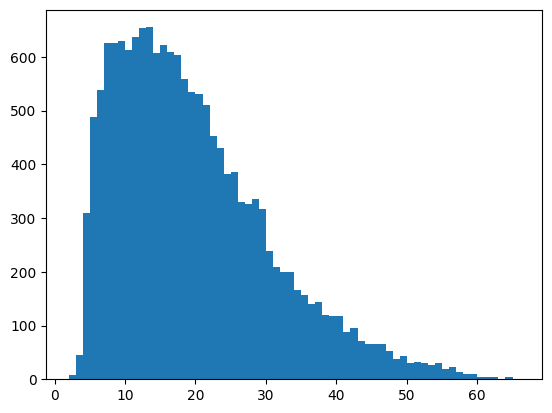

In [23]:
length=[len(x.split()) for x in tweets]
plt.hist(length,bins=len(set(length)))
plt.show()

In [24]:
maxlen=50

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
def get_sequences(tokenizer,tweets):
    sequences=tokenizer.texts_to_sequences(tweets)
    padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
    return padded

In [27]:
padded_train_seq=get_sequences(tokenizer,tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [28]:
classes=set(labels)
classes

{0, 1, 2, 3, 4, 5}

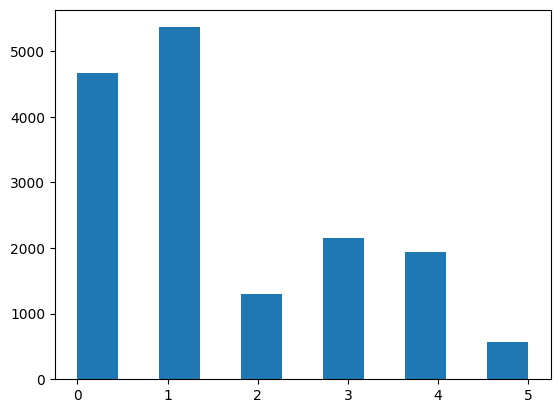

In [29]:
plt.hist(labels,11)
plt.show()

In [30]:
index_to_class={ 5:'surprise',1:'joy',0:'sadness',3:'anger',4:'fear',2:'love'}

In [31]:
class_to_index=dict((v,k) for k,v in index_to_class.items())

In [32]:
index_to_class

{5: 'surprise', 1: 'joy', 0: 'sadness', 3: 'anger', 4: 'fear', 2: 'love'}

In [33]:
id_to_names=lambda labels:np.array([index_to_class.get(x) for x in labels])
names_to_id=lambda labels:np.array(([class_to_index.get(x) for x in labels]))

In [34]:

train_labels=id_to_names(labels)
train_labels

array(['sadness', 'sadness', 'anger', ..., 'joy', 'anger', 'sadness'],
      dtype='<U8')

In [35]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [37]:
val_tweets=[]
val_labels=[]

In [38]:
with gzip.open('validation.jsonl.gz','rb') as f:
    for l in f:
        json_obj=json.loads(l.decode('utf-8'))
        val_tweets.append(json_obj['text'])
        val_labels.append(json_obj['label'])

In [39]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [40]:
val_seq=get_sequences(tokenizer,val_tweets)

In [41]:
train=np.array(labels)
padded_train_seq

array([[   2,  139,    3, ...,    0,    0,    0],
       [   2,   40,  101, ...,    0,    0,    0],
       [  17, 3060,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  327, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]])

In [42]:
val_labels=np.array(val_labels)
train = train.reshape(-1, 1,)
val_labels = val_labels.reshape(-1, 1)
# train = np.array(labels).reshape((-1,))
# val_labels = np.array(val_labels).reshape((-1,))

In [43]:

print("padded_train_seq shape:", padded_train_seq.shape)
# print("labels shape:", labels.shape)
print("train shape:", train.shape)
print("val_seq shape:", val_seq.shape)
print("val_labels shape:", val_labels.shape)



padded_train_seq shape: (16000, 50)
train shape: (16000, 1)
val_seq shape: (2000, 50)
val_labels shape: (2000, 1)


In [44]:
import traceback

try:
    h = model.fit(
        padded_train_seq,
        train,
        epochs=20,
        validation_data=(val_seq,val_labels),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
        ]
    )
except Exception as e:
    print(f"Error occurred: {e}")
    print("Error traceback:")
    traceback.print_tb(e.__traceback__)


Epoch 1/20
500/500 [==============================] - 24s 42ms/step - loss: 1.3302 - accuracy: 0.4895 - val_loss: 1.0520 - val_accuracy: 0.5920
Epoch 2/20
500/500 [==============================] - 22s 45ms/step - loss: 0.6973 - accuracy: 0.7549 - val_loss: 0.6089 - val_accuracy: 0.8035
Epoch 3/20
500/500 [==============================] - 29s 58ms/step - loss: 0.3837 - accuracy: 0.8742 - val_loss: 0.4491 - val_accuracy: 0.8530
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2278 - accuracy: 0.9274 - val_loss: 0.4080 - val_accuracy: 0.8715
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3340 - accuracy: 0.8969 - val_loss: 0.5477 - val_accuracy: 0.8240
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2407 - accuracy: 0.9224 - val_loss: 0.4007 - val_accuracy: 0.8670


In [45]:
# model.save('emotion_model_learning.h5')

In [46]:
model = tf.keras.models.load_model('emotion_model_learning.h5')

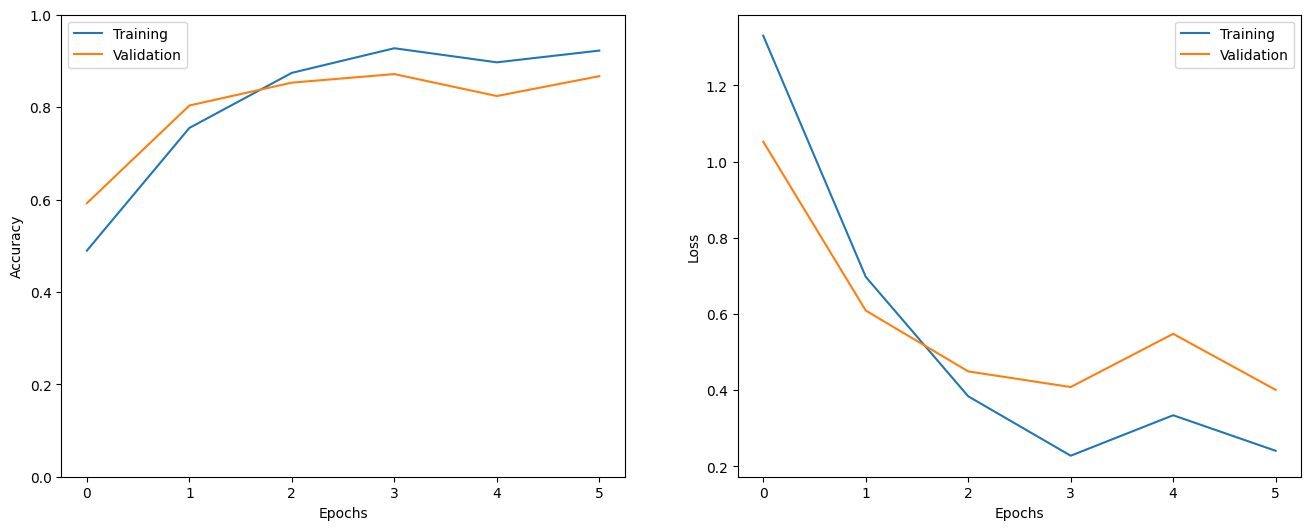

In [47]:
show_history(h)

In [48]:
eval_tweets,eval_labels=get_tweet('test.jsonl.gz')

In [49]:
test_seq=get_sequences(tokenizer,eval_tweets)
eval_labels=np.array(eval_labels)
eval_labels=eval_labels.reshape(-1,1)

In [50]:
a=model.evaluate(test_seq,np.array(eval_labels))

63/63 [==============================] - 2s 9ms/step - loss: 0.4822 - accuracy: 0.8795


In [62]:
i=random.randint(0,len(eval_labels)-1)
print('Sentence: ',eval_tweets[i])
print('Emotion: ',index_to_class[eval_labels[i][0]])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
# p=model.predict(eval_tweets[i])
pred_class=index_to_class[np.argmax(p).astype('uint8')]
print('predicted emotion: ',pred_class)

Sentence:  i took care of myself by avoiding family events that make me feel shitty
Emotion:  sadness
1/1 [==============================] - 0s 19ms/step
predicted emotion:  sadness
